In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')

In [2]:
df= pd.read_csv("/Users/luyin/Desktop/SP 18/train_ver2.csv",
                    usecols=['ncodpers','fecha_dato','ind_nuevo','ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 
                             'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
                             'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                             'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
                             'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
                             'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                             'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
                             'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
                             'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                             'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
                             'ind_viv_fin_ult1', 'ind_nomina_ult1',
                             'ind_nom_pens_ult1', 'ind_recibo_ult1'])

Recommender systems have a problem known as user cold-start, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.
For this reason, we are keeping in the dataset only customers with that are not new customers. 

In [3]:
df= df[df['ind_nuevo'] == 0]

In [4]:
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'], format='%Y-%m-%d', errors='coerce')
df['fecha_dato'].unique()

array(['2015-01-28T00:00:00.000000000', '2015-02-28T00:00:00.000000000',
       '2015-03-28T00:00:00.000000000', '2015-04-28T00:00:00.000000000',
       '2015-05-28T00:00:00.000000000', '2015-06-28T00:00:00.000000000',
       '2015-07-28T00:00:00.000000000', '2015-08-28T00:00:00.000000000',
       '2015-09-28T00:00:00.000000000', '2015-10-28T00:00:00.000000000',
       '2015-11-28T00:00:00.000000000', '2015-12-28T00:00:00.000000000',
       '2016-01-28T00:00:00.000000000', '2016-02-28T00:00:00.000000000',
       '2016-03-28T00:00:00.000000000', '2016-04-28T00:00:00.000000000',
       '2016-05-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [5]:
date_list = list(df['fecha_dato'].unique())
df_train = df[df.fecha_dato.isin(date_list[0:16])]

In [6]:
df_test = df.loc[df.fecha_dato==date_list[-1]]

In [9]:
df_train.tail()

,fecha_dato,ncodpers,ind_nuevo,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
12715851,2016-04-28,1297410,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715852,2016-04-28,1297411,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715853,2016-04-28,1297412,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1
12715854,2016-04-28,1297392,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715855,2016-04-28,1297395,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [18]:
df_test.head()

,fecha_dato,ncodpers,ind_nuevo,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
12715856,2016-05-28,657640,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715857,2016-05-28,657788,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715858,2016-05-28,657795,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715859,2016-05-28,657790,0.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1.0,1.0,1
12715860,2016-05-28,657794,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [10]:
df_customer1 = df_train.drop(['ind_nuevo','fecha_dato'], axis = 1)

In [11]:
df_product = df_train.drop(['ncodpers','ind_nuevo','fecha_dato'], axis = 1)

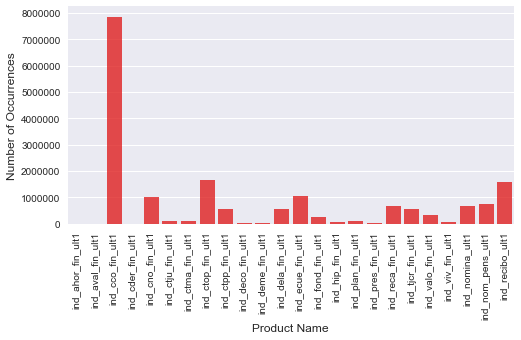

In [12]:
target_counts = df_product.astype('float64').sum(axis=0)
plt.figure(figsize=(8,4))
sns.barplot(target_counts.index, target_counts.values, alpha=0.8, color='red')
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [13]:
df_customer1.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,1375586,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,1050611,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,1050612,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,1050613,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,1050614,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


# Calculate tf-idf

In [15]:
TF = df_customer1.groupby(['ncodpers'],as_index = False, sort = False).sum().rename(columns = {'ncodpers': 'customer_id'})
TF_customer = pd.DataFrame(TF['customer_id'])
TF_customer.head()

,customer_id
0,1375586
1,1050611
2,1050612
3,1050613
4,1050614


In [16]:
user_id = TF_customer[:10000]
user_id.head()

,customer_id
0,1375586
1,1050611
2,1050612
3,1050613
4,1050614


In [19]:
TF_items = TF.drop(['customer_id'], axis = 1)
TF_items.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,3
1,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0.0,0.0,0
4,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [20]:
TF_ind = TF.set_index('customer_id')
TF_ind.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
customer_id,,,,,,,,,,,,,,,,,,,,,
1375586,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,3
1050611,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1050612,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1050613,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0.0,0.0,0
1050614,0,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [21]:
# #to obtain the IDF
DF_items = TF_ind.copy()
DF_items.shape[0]

891331

In [22]:
DF_items[DF_items > 0] = 1 #Unique Count of the items' frequency
DF_counts = DF_items.sum(axis=0)
DF_counts.head(24)

ind_ahor_fin_ult1        89.0
ind_aval_fin_ult1        23.0
ind_cco_fin_ult1     578423.0
ind_cder_fin_ult1       402.0
ind_cno_fin_ult1      80947.0
ind_ctju_fin_ult1      8254.0
ind_ctma_fin_ult1      9984.0
ind_ctop_fin_ult1    107563.0
ind_ctpp_fin_ult1     36982.0
ind_deco_fin_ult1      2162.0
ind_deme_fin_ult1      1846.0
ind_dela_fin_ult1     46790.0
ind_ecue_fin_ult1     76902.0
ind_fond_fin_ult1     17182.0
ind_hip_fin_ult1       5027.0
ind_plan_fin_ult1      7991.0
ind_pres_fin_ult1      2178.0
ind_reca_fin_ult1     45299.0
ind_tjcr_fin_ult1     57658.0
ind_valo_fin_ult1     23801.0
ind_viv_fin_ult1       3253.0
ind_nomina_ult1       65892.0
ind_nom_pens_ult1     70784.0
ind_recibo_ult1      147609.0
dtype: float64

In [23]:
IDF = np.log(DF_items.shape[0]/(DF_counts)) # this is the log of inverse DF, in case the DF_counts
IDF.head()

ind_ahor_fin_ult1     9.211835
ind_aval_fin_ult1    10.564977
ind_cco_fin_ult1      0.432410
ind_cder_fin_ult1     7.704019
ind_cno_fin_ult1      2.398921
dtype: float64

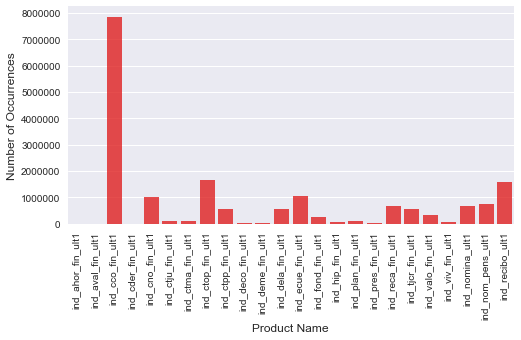

In [24]:
target_counts = df_product.astype('float64').sum(axis=0)
plt.figure(figsize=(8,4))
sns.barplot(target_counts.index, target_counts.values, alpha=0.8, color='red')
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

# Popularity Model

In [25]:
# popularity_recommend = sorted(target_counts, key=lambda x: x[1], reverse=True)
# pop_scores = list(target_counts)
df_target = pd.DataFrame(target_counts, columns=['counts'])
df_target.head()

,counts
ind_ahor_fin_ult1,1318.0
ind_aval_fin_ult1,297.0
ind_cco_fin_ult1,7857455.0
ind_cder_fin_ult1,5031.0
ind_cno_fin_ult1,1007626.0


In [26]:
# df_target.sort_values(by = ['counts'])
df_sort = df_target.reset_index()
df_sort = df_sort.sort_values(by = ['counts'], ascending=False)

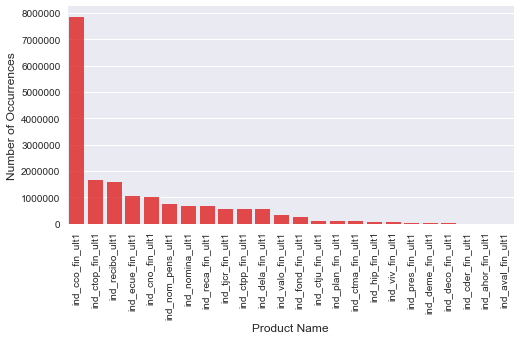

In [27]:
plt.figure(figsize=(8,4))
sns.barplot(df_sort['index'], df_sort['counts'], alpha=0.8, color='red')
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [28]:
df_sort.head(7)

,index,counts
2,ind_cco_fin_ult1,7857455.0
7,ind_ctop_fin_ult1,1658774.0
23,ind_recibo_ult1,1589246.0
12,ind_ecue_fin_ult1,1040211.0
4,ind_cno_fin_ult1,1007626.0
22,ind_nom_pens_ult1,740469.0
21,ind_nomina_ult1,681661.0


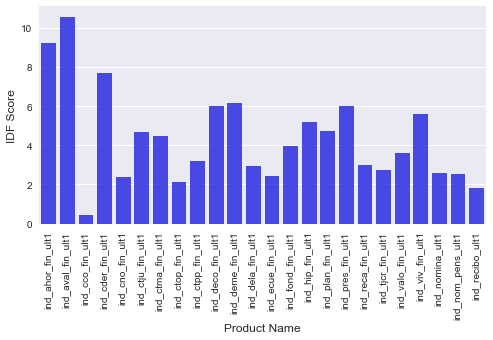

In [29]:
plt.figure(figsize=(8,4))
sns.barplot(IDF.index, IDF.values, alpha=0.8, color='blue')
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('IDF Score', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [30]:
TF_IDF = TF_items * IDF
TF_IDF.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.394447
1,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,12.043364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000



# Sampling on the first 10000 users

In [31]:
sample = TF_IDF[:10000]
sample.head(5)

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.394447
1,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,12.043364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [32]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
A_sparse = sparse.csr_matrix(sample)

similarities = cosine_similarity(A_sparse)
print('pairwise dense output:\n {}\n'.format(similarities))
print(similarities[0][1])
print(similarities.shape)
print(len(similarities.diagonal()))

pairwise dense output:
 [[ 1.          0.78861479  0.78861479 ...,  0.78861479  0.78861479
   0.78861479]
 [ 0.78861479  1.          1.         ...,  1.          1.          1.        ]
 [ 0.78861479  1.          1.         ...,  1.          1.          1.        ]
 ..., 
 [ 0.78861479  1.          1.         ...,  1.          1.          1.        ]
 [ 0.78861479  1.          1.         ...,  1.          1.          1.        ]
 [ 0.78861479  1.          1.         ...,  1.          1.          1.        ]]

0.788614788265
(10000, 10000)
10000


In [33]:
similarities[np.diag_indices_from(similarities)] = 0
print('pairwise dense output:\n {}\n'.format(similarities))

pairwise dense output:
 [[ 0.          0.78861479  0.78861479 ...,  0.78861479  0.78861479
   0.78861479]
 [ 0.78861479  0.          1.         ...,  1.          1.          1.        ]
 [ 0.78861479  1.          0.         ...,  1.          1.          1.        ]
 ..., 
 [ 0.78861479  1.          1.         ...,  0.          1.          1.        ]
 [ 0.78861479  1.          1.         ...,  1.          0.          1.        ]
 [ 0.78861479  1.          1.         ...,  1.          1.          0.        ]]



In [34]:
sim = pd.DataFrame(similarities)
sim['customer_id'] = user_id
sim.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,customer_id
0,0.000000,0.788615,0.788615,0.0,0.788615,0.788615,0.788615,0.788615,0.788615,0.716625,...,0.788615,0.788615,0.788615,0.788615,0.788615,0.788615,0.788615,0.788615,0.788615,1375586
1,0.788615,0.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.908714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1050611
2,0.788615,1.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.908714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1050612
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1050613
4,0.788615,1.000000,1.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.908714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1050614


In [35]:
# sim_id = sim.set_index('customer_id')
# sim_id.head()

Get Similiar Users First

In [47]:
indices = pd.Series(sim.index, index=sim['customer_id']).drop_duplicates()
top = 150
def get_similar_users(user_id, cosine_sim=similarities, top=top):
    u_idx = indices[user_id] #index of primary users
    sim_scores = list(enumerate(cosine_sim[u_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(top+1)]
    similar_user_indices = [i[0] for i in sim_scores]
    return u_idx, sim['customer_id'].iloc[similar_user_indices]

In [48]:
TF_IDF.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.394447
1,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,12.043364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,6.918567,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [49]:
# # Test
# l1 =TF_IDF.iloc[414]>0
# # print(product_idx['product_name'][0])
# for index, x in enumerate(l1):
#     if x == True:
#         print(product_idx['product_name'][index])

# # print(TF_IDF.columns)

In [50]:
top = 7
def get_recommendations(similar_user, score_df, top=top):
    output = []
    
    df_recm = similar_user[1]
    df_recm = pd.DataFrame(df_recm).reset_index()
    
    primary_user_idx = similar_user[0]
    product_idx = pd.DataFrame(score_df.columns, columns = ['product_name']) # Get product index
    user_idx = list(df_recm.iloc[:,0]) #get user index as a list
    
    for i in user_idx:
        l_1 =score_df.iloc[i]>0
        for index, x in enumerate(l_1):
            if x == True:
                item = product_idx['product_name'][index]
                if item not in output:
                    output.append(item)
    #Remove primary user items from output
    j = primary_user_idx
    l_0 = score_df.iloc[j]>0 # get the product list from the primary user
    for index, x in enumerate(l_0):
            if x == True:
                item = product_idx['product_name'][index]
                if item in output:
                    output.remove(item)
                
    if len(output) < top:
        return output
    else:
        return output[:(top)]

In [51]:
get_recommendations(get_similar_users(1375586), sample)

['ind_tjcr_fin_ult1']

# Genernating Prediction result

In [45]:
# create dictionary for the prediction result
def get_predict(sample):
    predict = {}
    for i in user_id['customer_id']:
        predict[i] = get_recommendations(get_similar_users(i), sample)
    return predict

        
predict_result = get_predict(sample)      
# iterator = iter(predict_result.items())
# count = 0
# for count in range(3):
#     count+=1
#     print(next(iterator))

In [46]:
iterator = iter(predict_result.items())
count = 0
for count in range(10):
    count+=1
    print(next(iterator))

(1375586, [])
(1050611, [])
(1050612, [])
(1050613, ['ind_cco_fin_ult1', 'ind_recibo_ult1', 'ind_reca_fin_ult1', 'ind_ecue_fin_ult1', 'ind_valo_fin_ult1', 'ind_cno_fin_ult1', 'ind_nomina_ult1'])
(1050614, [])
(1050615, [])
(1050616, [])
(1050617, [])
(1050619, [])
(1050620, [])


# Get compariable test set

In [52]:
df_test.head()

,fecha_dato,ncodpers,ind_nuevo,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
12715856,2016-05-28,657640,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715857,2016-05-28,657788,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715858,2016-05-28,657795,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
12715859,2016-05-28,657790,0.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1.0,1.0,1
12715860,2016-05-28,657794,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [53]:
df_remove = df[df.fecha_dato.isin(date_list[15:16])]
df_remove.head()

,fecha_dato,ncodpers,ind_nuevo,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
11787582,2016-04-28,896836,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.0,0.0,0
11787583,2016-04-28,896837,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787584,2016-04-28,896839,0.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0.0,0.0,0
11787585,2016-04-28,896853,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
11787586,2016-04-28,896849,0.0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0.0,0.0,0


In [54]:
# df_test[df_test['ncodpers'] == '1375586']
a = df_test[df_test['ncodpers'] == 1375586]
a = a.iloc[:,3:28]
for items in a.columns:
    if a[items].item()>0:
        print(items)
b = a.T
c = b[b[13226584]>0]
l = list(c.index)

ind_cco_fin_ult1
ind_recibo_ult1


In [55]:
df_test[df_test['ncodpers'] == 1050613]

,fecha_dato,ncodpers,ind_nuevo,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
13431098,2016-05-28,1050613,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [56]:
def get_list(df):
    d = {}
    id_ = df['ncodpers']
    for i in id_:
        a = df[id_ == i]
        l = []
        for items in a.columns:
            b = a[items].item()
            if b > 0 and b < 17:
                l.append(items)
        d[i] = l
    return(d)

In [62]:
q2 = get_list(df_remove)

In [59]:
q1 = get_list(df_test)

In [61]:
def get_test(d_t,d_r):
    test = {}
    for key, value in d_t.items():
        list1 = value
        if key in d_r.keys():
            list2 = d_r[key]
            for x in list1:
                if x in list2:
                    list1.remove(x)
        test[key] = list1
    return(test)   

In [63]:
tt = get_test(q1,q2)

In [66]:
iterator_1 = iter(tt.items())
count = 0
for count in range(10):
    count+=1
    print(next(iterator_1))

(657640, [])
(657788, [])
(657795, [])
(657790, ['ind_ecue_fin_ult1', 'ind_nomina_ult1', 'ind_recibo_ult1'])
(657794, ['ind_dela_fin_ult1'])
(657797, [])
(657789, ['ind_ctpp_fin_ult1', 'ind_tjcr_fin_ult1'])
(657787, [])
(657777, [])
(657782, [])


# MAP@7 Calculation

In [67]:
actual = ['ind_cco_fin_ult1', 'ind_recibo_ult1', 'ind_tjcr_fin_ult1']

In [68]:
predicted = ['ind_tjcr_fin_ult1']

In [88]:
def average_precision(actual, predicted, k=7):
    
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    if len(predicted) == 0 and len(actual) == 0:
        return 1

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        

    if not actual:
        return 0.0
    return score / min(len(actual), k)
    

In [70]:
average_precision(actual, predicted)

0.3333333333333333

In [71]:
def mapk(actual, predicted, k=7):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [77]:
len(set(tt.keys()) & set(predict_result.keys())) #common key between test and predict

9891

In [79]:
def get_map(actual, predict, k = 7):
    count = 0
    ap = 0
    for key , value in predict.items():
        list1 = value
        if key in actual.keys():
            list2 = actual[key]
            ap+= average_precision(list2, list1)
            count+=1
    if count == 0:
        return np.nan
    else:
        result = ap/count
        return result

In [89]:
get_map(tt, predict_result)

0.8313590357114774


# Referene

Use both Jaccard Similarity and Cosine Similarity

In [ ]:
# from sklearn.metrics import jaccard_similarity_score
# import scipy.spatial as sp

# # 1 - sp.distance.cdist(matrix1, matrix2, 'cosine') #this is the consin similarity of two matrix
# # 1- sp.distance.cdist(matrix1, matrix2, 'jaccard') # this is the jaccard similarity of two matrix



In [ ]:
# TF= .groupby(['ncodpers'], as_index = False, sort = False).count().rename(columns = {‘userId’: ‘tag_count_TF’})[[‘movieId’,’tag’,’tag_count_TF’]]
# Tag_distinct = Tags[[‘tag’,’movieId’]].drop_duplicates()
# DF =Tag_distinct.groupby([‘tag’], as_index = False, sort = False).count().rename(columns = {‘movieId’: ‘tag_count_DF’})[[‘tag’,’tag_count_DF’]]
# a=math.log10(24)
# DF[‘IDF’]=a-np.log10(DF[‘tag_count_DF’])
# TF = pd.merge(TF,DF,on = ‘tag’, how = ‘left’, sort = False)
# TF[‘TF-IDF’]=TF[‘tag_count_TF’]*TF[‘IDF’]

In [ ]:
# df = pd.DataFrame({"A":["foo", "foo", "foo", "bar"], "B":[0,1,1,1], "C":["A","A","B","A"]})
# df.drop_duplicates(subset=['A', 'C'], keep=False).reset_index(drop=True)

For each user: sample 500 users from the population and calculate the similarities
Calculate 

In [ ]:
# from sklearn.metrics import jaccard_similarity_score

# print(jaccard_similarity_score(A, B))